## Feature Extraction: Coherence

In [11]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.coherence import EEGCoherence
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Global Variables
NUM_CHANNELS = 16
MODMA_SFREQ = 250
EEG_DIR_PATH = os.getenv("EEG_DIR_PATH")
RAW_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/raw"
SELECT_16_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/16channels"
FILTERED_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/filtered"
EPOCHS_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/epochs"

# Declare Feature Dictionary
featureDict = {
    "coherence": {
        "mdd": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            },
        "control": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            }
        }
    } 


In [12]:
# Load the epochs
mddEpochs = mne.read_epochs(EPOCHS_DIR_PATH + "/mdd-epo.fif")
controlEpochs = mne.read_epochs(EPOCHS_DIR_PATH + "/control-epo.fif")
mddEpochs = mddEpochs.get_data()
controlEpochs = controlEpochs.get_data()
print(mddEpochs.shape)
print(controlEpochs.shape)

Reading /Users/wachiii/Workschii/brain-mdd/data/epochs/mdd-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/wachiii/Workschii/brain-mdd/data/epochs/control-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1753 matching events found
No baseline correction applied
0 projection items activated
(1328, 16, 1250)
(1753, 16, 1250)


In [13]:
coherenceObjMdd = EEGCoherence(mddEpochs, MODMA_SFREQ)
mddCohFeatures = coherenceObjMdd.run()
coherenceObjControl = EEGCoherence(controlEpochs, MODMA_SFREQ)
controlCohFeatures = coherenceObjControl.run()

print(mddCohFeatures.shape)
print(controlCohFeatures.shape)

(1328, 5, 120)
(1753, 5, 120)


In [14]:
for epoch in mddCohFeatures:
    bandCounter = 0
    for band in epoch:
        if bandCounter == 0:
            featureDict["coherence"]["mdd"]["delta"].append(band)
        elif bandCounter == 1:
            featureDict["coherence"]["mdd"]["theta"].append(band)
        elif bandCounter == 2:
            featureDict["coherence"]["mdd"]["alpha"].append(band)
        elif bandCounter == 3:
            featureDict["coherence"]["mdd"]["beta"].append(band)
        elif bandCounter == 4:
            featureDict["coherence"]["mdd"]["gamma"].append(band)
        bandCounter += 1

for epoch in controlCohFeatures:
    bandCounter = 0
    for band in epoch:
        if bandCounter == 0:
            featureDict["coherence"]["control"]["delta"].append(band)
        elif bandCounter == 1:
            featureDict["coherence"]["control"]["theta"].append(band)
        elif bandCounter == 2:
            featureDict["coherence"]["control"]["alpha"].append(band)
        elif bandCounter == 3:
            featureDict["coherence"]["control"]["beta"].append(band)
        elif bandCounter == 4:
            featureDict["coherence"]["control"]["gamma"].append(band)
        bandCounter += 1     

In [7]:
# check the shape of the features
print(len(featureDict["coherence"]["mdd"]["delta"]))
print(len(featureDict["coherence"]["mdd"]["theta"]))
print(len(featureDict["coherence"]["mdd"]["alpha"]))
print(len(featureDict["coherence"]["mdd"]["beta"]))
print(len(featureDict["coherence"]["mdd"]["gamma"]))
print(len(featureDict["coherence"]["control"]["delta"]))
print(len(featureDict["coherence"]["control"]["theta"]))
print(len(featureDict["coherence"]["control"]["alpha"]))
print(len(featureDict["coherence"]["control"]["beta"]))
print(len(featureDict["coherence"]["control"]["gamma"]))


1328
1328
1328
1328
1328
1753
1753
1753
1753
1753


## Classification

Accuracy:  0.8038897893030794
Precision:  0.7762711864406779
Recall:  0.8063380281690141
F1 Score:  0.7910189982728842


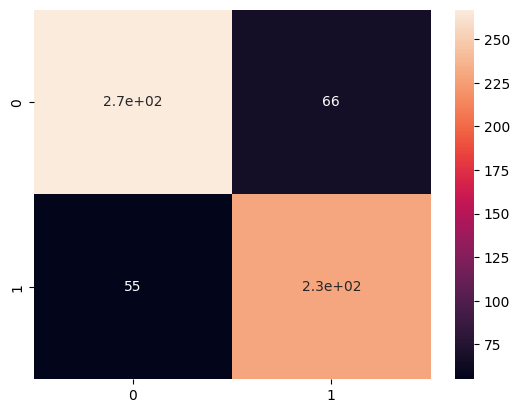

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

deltaMdd = featureDict["coherence"]["mdd"]["delta"]
deltaControl = featureDict["coherence"]["control"]["delta"]
deltaMdd = np.array(deltaMdd)
deltaControl = np.array(deltaControl)

X = np.concatenate((deltaMdd, deltaControl), axis=0)
y = np.concatenate((np.ones(len(deltaMdd)), np.zeros(len(deltaControl))), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()